In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 추가 메모리

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

#  /device:GPU:0 뜨면 gpu 연결된거임

'/device:GPU:0'

In [ ]:
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 38.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 47.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from konlpy.tag import Okt

# 데이터 전처리
### 5점 9000개는 4,3,2점에서 불용어 처리한거 무조건 넣기 + 9000개 랜덤 / 4,3,2점 불용어 처리

In [ ]:
# 데이터 불러오기
file_path = '/content/drive/My Drive/Colab Notebooks/unique_reviews.csv'

In [ ]:
reviews_df = pd.read_csv(file_path)

In [ ]:

exclude_words = ["좋아", "좋아요", "이뻐요", "이쁩니다", "특템했었요", "예뻐요", "예뻐", "이뻐서", "편해요", "편해", "편하다", "편함", "굿",
                 "굳", "예뻐서", "맞아요~", "즇아요", "맞아요!","멋져","멋있음","멋있다","멋짐","득템","득템했다","편하게","편하고","좋습니다","멋있음"]


exclude_words_pattern = '|'.join(exclude_words)


filtered_reviews = reviews_df[
    (reviews_df['score'].isin([2, 3, 4])) &
    (~reviews_df['review'].str.contains(exclude_words_pattern, na=False))
]


one_star_reviews = reviews_df[reviews_df['score'] == 1]


negative_combined_reviews = pd.concat([filtered_reviews, one_star_reviews])


In [ ]:
# 5점 리뷰에서 리뷰만 뽑아오기
five_star_reviews = reviews_df[reviews_df['score'] == 5.0]

# 긍정적인 키워드 리스트 정의
positive_keywords = ["좋아", "좋아요", "이뻐요", "이쁩니다", "특템했었요", "예뻐요", "예뻐", "이뻐서", "편해요", "편해",
                     "편하다", "편함", "굿", "굳", "예뻐서", "맞아요~", "즇아요", "맞아요!", "멋져", "멋있다", "멋짐",
                     "득템", "득템했다", "편하게", "편하고", "좋습니다", "멋있음"]

# 긍정적인 키워드가 포함된 리뷰 필터링
positive_reviews = five_star_reviews[five_star_reviews['review'].apply(lambda x: any(keyword in x for keyword in positive_keywords))]

# 긍정적인 키워드가 포함된 리뷰에서 10,000개 랜덤 샘플링
sampled_positive_reviews = positive_reviews.sample(9000, random_state=1)

# 남은 리뷰에서 10,000개 랜덤 샘플링
remaining_reviews = five_star_reviews.drop(sampled_positive_reviews.index)
sampled_remaining_reviews = remaining_reviews.sample(9000, random_state=1)

# 샘플링된 리뷰 합치기
positive_reviews_sampled = pd.concat([sampled_positive_reviews, sampled_remaining_reviews])

In [ ]:
# 최종 데이터 결합
final_combined_reviews = pd.concat([negative_combined_reviews, positive_reviews_sampled])

In [ ]:
# 데이터 셔플
final_combined_reviews = final_combined_reviews.sample(frac=1, random_state=42)

# 최종 데이터 개수 확인
positive_reviews_count = len(positive_reviews_sampled)
negative_reviews_count = len(negative_combined_reviews)
total_count = len(final_combined_reviews)

print(f"긍정 집합 (5점 리뷰): {positive_reviews_count}개")
print(f"부정 집합 (1, 2, 3, 4점 리뷰): {negative_reviews_count}개")
print(f"총 개수: {total_count}개")

긍정 집합 (5점 리뷰): 18000개
부정 집합 (1, 2, 3, 4점 리뷰): 11354개
총 개수: 29354개


In [ ]:
# 최종 데이터셋 저장
final_combined_reviews.to_csv('/content/drive/My Drive/Colab Notebooks/best_combined_reviews.csv', encoding ='utf-8')

# 내가 원하는 모델 만들기

In [ ]:
# 데이터 불러오기
file_path = '/content/drive/My Drive/Colab Notebooks/best_combined_reviews.csv'
reviews_df = pd.read_csv(file_path)

In [ ]:
reviews_df['sentiment'] = reviews_df['score'].apply(lambda x: 1 if x == 5 else 0)

In [ ]:
reviews_df

,Unnamed: 0.1,Unnamed: 0,name,date,product,detail,score,review,help_cnt,style_cnt,type,category,sex,price,tag,sentiment
0,87624,47.0,LV.6 블루월드인미,2024.02.05,공용 CROCBAND WT (23SUCL11016),WHITE(Z100)/M9W11(270),4.0,"여행가서 착용하려고 급히 구매했는데, 빠른배송으로 잘 받았구요~ 가볍고 발볼이 넓어...",0,0.0,style,샌들,"남성, 여성",74900,"사이즈-보통이에요, 밝기-밝아요, 색감-선명해요, 발볼-넓어요, 착화감-편안해요, ...",0
1,62105,215.0,LV.5 한주떼이,2023.08.04,미니멀 플립플랍 (블랙),41,4.0,적당한 굽에 아무데나 다 잘어울려서 스타일링 하기 좋음,0,NaN,general,슬리퍼,"남성, 여성",49000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",0
2,35157,1293.0,LV.5 yooozoo,2021.04.19,WALLABEE 26155515,CLA-26155515_270,5.0,신발 예쁩니다 !! 보들보들 착화감도 너무 편해요 구매하세용,0,NaN,product,모카신/보트 슈즈,"남성, 여성",248000,"사이즈-커요, 밝기-보통이에요, 색감-선명해요, 발볼-넓어요, 착화감-편안해요",1
3,87233,229.0,LV.4 꿝쀍,2022.09.11,웨버 버블 플립플랍 (0087849) WV21109 BK,270,5.0,처음엔 발가락이 좀 아팠는데 신다보니 적응 돼서 괜찮아졌습니다. 놀러갈때 신었는데 ...,0,NaN,general,슬리퍼,"남성, 여성",19000,"사이즈-보통이에요, 밝기-어두워요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당해요",1
4,42074,25.0,LV.7 ckd2,2021.12.08,1461 쿼드 블랙 폴리시드 스무스 / 25567001,280,4.0,"원래 평균 275~280 신는데, 280 약간 여유있게 잘 맞습니다. 한치수 크게 ...",6,1.0,style,구두,"남성, 여성",250000,"사이즈-보통이에요, 밝기-보통이에요, 색감-선명해요, 발볼-보통이에요, 착화감-딱딱해요",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29349,33002,61.0,LV.5 므므므므믐,2021.12.07,WALLABEE 26155515,CLA-26155515_265,5.0,정사이즈로 샀는데 조금 크게 나온건 맞네요! 그리고 밑창 소재가 신기해요!,1,5.0,style,모카신/보트 슈즈,"남성, 여성",248000,"사이즈-커요, 밝기-보통이에요, 색감-보통이에요, 발볼-넓어요, 착화감-적당해요",1
29350,59287,147.0,LV.5 고독핏,2021.09.01,미니멀 플립플랍 (블랙),42,3.0,신으면 발등이 까져서 너무 아팠습니다. 계속 신으면 나아질지 잘 모르겠네요ㅕ ㅜㅜ,0,2.0,style,슬리퍼,"남성, 여성",49000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당해요",0
29351,8666,237.0,LV.5 탐나는휴스턴컷팅,2023.08.15,슈퍼 무신사 에디션,Brown Edition/245,4.0,세상 편한 신발입니닺\n신발이 깔끔해서 어디든 잘 어울립니다.,0,NaN,general,샌들,여성,85000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",0
29352,42092,43.0,LV.5 HANI98,2023.09.19,1461 쿼드 블랙 폴리시드 스무스 / 25567001,220,5.0,배송이 정말 빨랐고 매장에서 이미 신어보고 산거라서 사이즈는 잘 선택한 거 같습니다...,1,3.0,style,구두,"남성, 여성",250000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",1


In [ ]:
# SCORE_SENTIMENT 컬럼을 라벨로 사용
reviews_df['label'] = reviews_df['sentiment']

# 데이터 분할: 훈련 데이터와 검증 데이터로 나눔 (테스트 세트 20%)
train_df, eval_df = train_test_split(reviews_df, test_size=0.2, random_state=42)

# Okt 형태소 분석기 초기화
okt = Okt()

# 텍스트 전처리 함수
def preprocess_text(text):
    tokens = okt.morphs(text, stem=True)
    return ' '.join(tokens)

# 데이터셋 클래스 정의
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# 데이터 전처리
tqdm.pandas()
train_df['cleaned_review'] = train_df['review'].progress_apply(preprocess_text)
eval_df['cleaned_review'] = eval_df['review'].progress_apply(preprocess_text)

# 토크나이저 및 데이터셋 준비
model_name = "monologg/kobert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 128

train_dataset = ReviewDataset(
    reviews=train_df['cleaned_review'].to_numpy(),
    labels=train_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_length=max_length
)

eval_dataset = ReviewDataset(
    reviews=eval_df['cleaned_review'].to_numpy(),
    labels=eval_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_length=max_length
)

100%|██████████| 5871/5871 [00:21<00:00, 269.81it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset, DataLoader  # DataLoader import 추가

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

In [ ]:
# 데이터 로더 준비
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

# 모델 준비
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# EarlyStoppingCallback 추가
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # 성능 향상이 없을 경우 몇 번의 에포크 후 중지할지 설정
    early_stopping_threshold=0.0  # 성능 향상 기준 임계값
)

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# 모델 훈련
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.624800,0.675205
2,0.584700,0.587556
3,0.608000,0.581534
4,0.521500,0.579960
5,0.510500,0.579501


TrainOutput(global_step=1835, training_loss=0.575430511193964, metrics={'train_runtime': 1170.9533, 'train_samples_per_second': 100.273, 'train_steps_per_second': 1.567, 'total_flos': 7723296141273600.0, 'train_loss': 0.575430511193964, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# 메트릭 함수를 정의
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Trainer 설정 (기존 trainer 설정에 메트릭 함수를 추가)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 모델 평가
eval_result = trainer.evaluate(eval_dataset=eval_dataset)
print(f"Evaluation results: {eval_result}")


Evaluation results: {'eval_loss': 0.5795009136199951, 'eval_accuracy': 0.7097598364844149, 'eval_precision': 0.7357320099255583, 'eval_recall': 0.8226970033296337, 'eval_f1': 0.7767880534451139, 'eval_runtime': 20.3574, 'eval_samples_per_second': 288.397, 'eval_steps_per_second': 4.519}


In [ ]:
# 모델 훈련 후 저장
model_save_path = '/content/drive/My Drive/Colab Notebooks/best_value_review_musinsa_model'
trainer.save_model(model_save_path)

In [ ]:
# 원본 데이터 로드
new_file_path = '/content/drive/My Drive/Colab Notebooks/unique_reviews.csv'
new_reviews_df = pd.read_csv(new_file_path)

In [ ]:
new_reviews_df

,Unnamed: 0,name,date,product,detail,score,review,help_cnt,style_cnt,type,category,sex,price,tag
0,0.0,LV.5 oct21,2023.07.30,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/235mm,5.0,푹신푹신해서 오래신어두 발 안아프고 좋으네용\n어느 코디에든 휘뚤마뚤 신을 수 있어...,2,4.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-편..."
1,1.0,LV.4 교쟈만듀,2023.06.14,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/cream/245mm,5.0,치마 원피스 바지에 무난하게 잘 어울려서 코디 하기 좋아요!\n그리고 신고 벗기가 ...,4,2.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-선명해요, 발볼-넓어요, 착화감-편안해요..."
2,2.0,LV.5 Trust_m,2023.06.24,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/250mm,5.0,유니크하구 편안해보여서 구매했는데 역시 딱 좋습니다! 오래 신을 거 같아요! 정사이...,2,3.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적..."
3,3.0,LV.5 닝낭농낭,2023.07.27,노트 스트링 플랫폼 샌들(남여공용)[n5212],men/black/275mm,4.0,일단 생긴게 유니크하고 이뻐서 여름에 자주 신을 것 같습니다. 굽도 꽤 있어서 키높...,2,2.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-어두워요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당..."
4,4.0,LV.3 웅스젱,2023.11.15,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/240mm,5.0,"좋아욥!! 궈여워요~~ 그치만 발에 땀이 나면 곤란해요,,",2,1.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114661,23.0,LV.5 YaHho,4일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU8/(270),5.0,생각보다 너무 가볍고\n사이즈도 절 맞아요\n특히 컬러가 너무 마음에 들어 좋네요,0,0.0,style,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적..."
114662,24.0,LV.7 지추니니니,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU7/(260~265),5.0,아주 맘에 듭니다 배송 받자마자 신고 나갔다가 왔어여,0,0.0,style,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적..."
114663,14.0,LV.7 지추니니니,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU7/(260~265),5.0,발도 편안하고 여기저기 잘 어울리는 디자인이어서 좋아요,0,NaN,product,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적..."
114664,15.0,LV.4 루뗄라,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU6/(250~255),5.0,디자인 구두같은 정갈한 느낌은 아니고 캐주얼에 더 잘어울리는 느낌이에요.\n사이즈는...,0,NaN,product,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적..."


In [ ]:
# Okt 형태소 분석기 초기화
okt = Okt()

# 텍스트 전처리 함수
def preprocess(text):
    tokens = okt.morphs(text, stem=True)
    return ' '.join(tokens)


In [ ]:
tqdm.pandas()

In [ ]:
# 새로운 데이터 전처리

new_reviews_df['cleaned_review'] = new_reviews_df['review'].apply(preprocess)

In [ ]:
new_reviews_df

,Unnamed: 0,name,date,product,detail,score,review,help_cnt,style_cnt,type,category,sex,price,tag,cleaned_review
0,0.0,LV.5 oct21,2023.07.30,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/235mm,5.0,푹신푹신해서 오래신어두 발 안아프고 좋으네용\n어느 코디에든 휘뚤마뚤 신을 수 있어...,2,4.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-편...",푹신푹신 하다 오래 신어 두 발 안 아프다 좋다 네 용 \n 어느 코디 에든 휘뚤마...
1,1.0,LV.4 교쟈만듀,2023.06.14,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/cream/245mm,5.0,치마 원피스 바지에 무난하게 잘 어울려서 코디 하기 좋아요!\n그리고 신고 벗기가 ...,4,2.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-선명해요, 발볼-넓어요, 착화감-편안해요...",치마 원피스 바지 에 무난 하다 자다 어울리다 코디 하다 좋다 ! \n 그리고 신고...
2,2.0,LV.5 Trust_m,2023.06.24,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/250mm,5.0,유니크하구 편안해보여서 구매했는데 역시 딱 좋습니다! 오래 신을 거 같아요! 정사이...,2,3.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",유니크 하다 편안 해보다 구매 하다 역시 딱 좋다 ! 오래 신 을 거 같다 ! 정사...
3,3.0,LV.5 닝낭농낭,2023.07.27,노트 스트링 플랫폼 샌들(남여공용)[n5212],men/black/275mm,4.0,일단 생긴게 유니크하고 이뻐서 여름에 자주 신을 것 같습니다. 굽도 꽤 있어서 키높...,2,2.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-어두워요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당...",일단 생기다 유니크 하고 이쁘다 여름 에 자주 신 을 것 같다 . 굽 도 꽤 있다 ...
4,4.0,LV.3 웅스젱,2023.11.15,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/240mm,5.0,"좋아욥!! 궈여워요~~ 그치만 발에 땀이 나면 곤란해요,,",2,1.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...","좋다 욥 !! 궈여워 요 ~~ 그치다 발 에 땀 이 나다 곤란하다 ,,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114661,23.0,LV.5 YaHho,4일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU8/(270),5.0,생각보다 너무 가볍고\n사이즈도 절 맞아요\n특히 컬러가 너무 마음에 들어 좋네요,0,0.0,style,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",생각 보다 너무 가볍다 \n 사이즈 도 절 맞다 \n 특히 컬러 가 너무 마음 에 ...
114662,24.0,LV.7 지추니니니,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU7/(260~265),5.0,아주 맘에 듭니다 배송 받자마자 신고 나갔다가 왔어여,0,0.0,style,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",아주 맘 에 듭니 다 배송 받다 신고 나가다 오다
114663,14.0,LV.7 지추니니니,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU7/(260~265),5.0,발도 편안하고 여기저기 잘 어울리는 디자인이어서 좋아요,0,NaN,product,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",발도 편안하다 여기저기 자다 어울리다 디자인 이어서 좋다
114664,15.0,LV.4 루뗄라,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU6/(250~255),5.0,디자인 구두같은 정갈한 느낌은 아니고 캐주얼에 더 잘어울리는 느낌이에요.\n사이즈는...,0,NaN,product,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",디자인 구두 같다 정갈하다 느낌 은 아니다 캐 주얼 에 더 잘 어울리다 느낌 이에요...


In [ ]:
# 모델 및 토크나이저 로드
model_path = '/content/drive/My Drive/Colab Notebooks/best_value_review_musinsa_model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 모델을 평가 모드로 설정
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [ ]:
# 예측 수행 함수
def predict(texts):
    predictions = []
    predicted_classes = []
    for text in tqdm(texts, desc="Predicting"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).numpy()
            predictions.append(probs[0])  # 각 예측 확률을 리스트에 추가
            predicted_class = probs.argmax(axis=-1)
            predicted_classes.append(predicted_class[0])
    return predictions, predicted_classes

In [ ]:
# 새로운 데이터에 대한 예측 수행
new_texts = new_reviews_df['cleaned_review'].tolist()
predictions, predicted_classes = predict(new_texts)

Predicting: 100%|██████████| 114666/114666 [1:06:29<00:00, 28.74it/s]


In [ ]:
# 예측 결과의 길이 확인
print(f"Length of dataframe: {len(new_reviews_df)}")
print(f"Length of predictions: {len(predictions)}")
print(f"Length of predicted_classes: {len(predicted_classes)}")

Length of dataframe: 114666
Length of predictions: 114666
Length of predicted_classes: 114666


In [ ]:
# 예측 결과를 문자열로 변환하여 데이터프레임에 추가
new_reviews_df['predictions'] = predictions

In [ ]:
new_reviews_df['predicted_class'] = predicted_classes

In [ ]:
new_reviews_df

,Unnamed: 0,name,date,product,detail,score,review,help_cnt,style_cnt,type,category,sex,price,tag,cleaned_review,predictions,predicted_class
0,0.0,LV.5 oct21,2023.07.30,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/235mm,5.0,푹신푹신해서 오래신어두 발 안아프고 좋으네용\n어느 코디에든 휘뚤마뚤 신을 수 있어...,2,4.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-편...",푹신푹신 하다 오래 신어 두 발 안 아프다 좋다 네 용 \n 어느 코디 에든 휘뚤마...,"[0.07328431, 0.9267157]",1
1,1.0,LV.4 교쟈만듀,2023.06.14,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/cream/245mm,5.0,치마 원피스 바지에 무난하게 잘 어울려서 코디 하기 좋아요!\n그리고 신고 벗기가 ...,4,2.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-선명해요, 발볼-넓어요, 착화감-편안해요...",치마 원피스 바지 에 무난 하다 자다 어울리다 코디 하다 좋다 ! \n 그리고 신고...,"[0.8330031, 0.16699688]",0
2,2.0,LV.5 Trust_m,2023.06.24,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/250mm,5.0,유니크하구 편안해보여서 구매했는데 역시 딱 좋습니다! 오래 신을 거 같아요! 정사이...,2,3.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",유니크 하다 편안 해보다 구매 하다 역시 딱 좋다 ! 오래 신 을 거 같다 ! 정사...,"[0.18397099, 0.816029]",1
3,3.0,LV.5 닝낭농낭,2023.07.27,노트 스트링 플랫폼 샌들(남여공용)[n5212],men/black/275mm,4.0,일단 생긴게 유니크하고 이뻐서 여름에 자주 신을 것 같습니다. 굽도 꽤 있어서 키높...,2,2.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-어두워요, 색감-보통이에요, 발볼-보통이에요, 착화감-적당...",일단 생기다 유니크 하고 이쁘다 여름 에 자주 신 을 것 같다 . 굽 도 꽤 있다 ...,"[0.26730466, 0.7326953]",1
4,4.0,LV.3 웅스젱,2023.11.15,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/240mm,5.0,"좋아욥!! 궈여워요~~ 그치만 발에 땀이 나면 곤란해요,,",2,1.0,style,샌들,"남성, 여성",89000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...","좋다 욥 !! 궈여워 요 ~~ 그치다 발 에 땀 이 나다 곤란하다 ,,","[0.625064, 0.374936]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114661,23.0,LV.5 YaHho,4일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU8/(270),5.0,생각보다 너무 가볍고\n사이즈도 절 맞아요\n특히 컬러가 너무 마음에 들어 좋네요,0,0.0,style,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",생각 보다 너무 가볍다 \n 사이즈 도 절 맞다 \n 특히 컬러 가 너무 마음 에 ...,"[0.25355726, 0.7464427]",1
114662,24.0,LV.7 지추니니니,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU7/(260~265),5.0,아주 맘에 듭니다 배송 받자마자 신고 나갔다가 왔어여,0,0.0,style,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",아주 맘 에 듭니 다 배송 받다 신고 나가다 오다,"[0.16619684, 0.8338031]",1
114663,14.0,LV.7 지추니니니,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU7/(260~265),5.0,발도 편안하고 여기저기 잘 어울리는 디자인이어서 좋아요,0,NaN,product,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",발도 편안하다 여기저기 자다 어울리다 디자인 이어서 좋다,"[0.22862059, 0.77137935]",1
114664,15.0,LV.4 루뗄라,5일 전,ORIGINAL 1910 첼시부츠_스틸그레이,AU6/(250~255),5.0,디자인 구두같은 정갈한 느낌은 아니고 캐주얼에 더 잘어울리는 느낌이에요.\n사이즈는...,0,NaN,product,부츠,"남성, 여성",269000,"사이즈-보통이에요, 밝기-보통이에요, 색감-보통이에요, 발볼-보통이에요, 착화감-적...",디자인 구두 같다 정갈하다 느낌 은 아니다 캐 주얼 에 더 잘 어울리다 느낌 이에요...,"[0.19147922, 0.80852073]",1


predicted_class         0         1
score                              
1.0              0.809955  0.190045
2.0              0.775000  0.225000
3.0              0.693425  0.306575
4.0              0.464586  0.535414
5.0              0.188698  0.811302


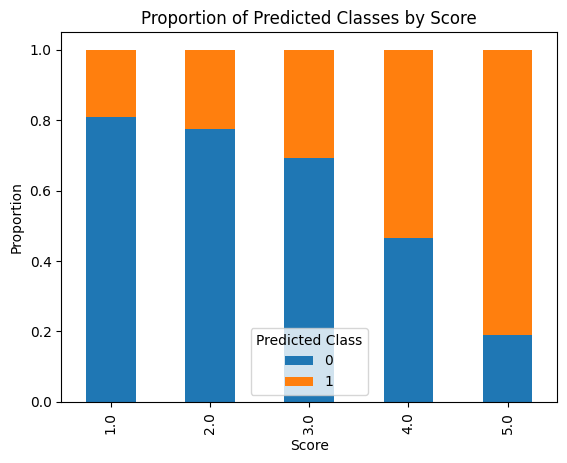

In [ ]:
# score 별 predicted_class 비율 계산
score_class_distribution = new_reviews_df.groupby('score')['predicted_class'].value_counts(normalize=True).unstack().fillna(0)

# 비율 출력
print(score_class_distribution)

# 시각화
import matplotlib.pyplot as plt

score_class_distribution.plot(kind='bar', stacked=True)
plt.xlabel('Score')
plt.ylabel('Proportion')
plt.title('Proportion of Predicted Classes by Score')
plt.legend(title='Predicted Class')
plt.show()

In [ ]:
# 데이터프레임의 열 확인
print(new_reviews_df.columns)

Index(['Unnamed: 0', 'name', 'date', 'product', 'detail', 'score', 'review',
       'help_cnt', 'style_cnt', 'type', 'category', 'sex', 'price', 'tag',
       'cleaned_review', 'predictions', 'predicted_class'],
      dtype='object')


In [ ]:
# 저장할 열 선택 (왜인지 모르겠으나 new_reviews_df가 csv로 완전히 안가져와서 원하는 특정컬럼만 가지고옴)
desired_columns = [
    'product', 'detail', 'score', 'review', 'help_cnt', 'style_cnt',
    'category', 'price', 'cleaned_review', 'predictions', 'predicted_class'
]
new_reviews_df_filtered = new_reviews_df[desired_columns]

In [ ]:
new_reviews_df_filtered

,product,detail,score,review,help_cnt,style_cnt,category,price,cleaned_review,predictions,predicted_class
0,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/235mm,5.0,푹신푹신해서 오래신어두 발 안아프고 좋으네용\n어느 코디에든 휘뚤마뚤 신을 수 있어...,2,4.0,샌들,89000,푹신푹신 하다 오래 신어 두 발 안 아프다 좋다 네 용 \n 어느 코디 에든 휘뚤마...,"[0.07328431, 0.9267157]",1
1,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/cream/245mm,5.0,치마 원피스 바지에 무난하게 잘 어울려서 코디 하기 좋아요!\n그리고 신고 벗기가 ...,4,2.0,샌들,89000,치마 원피스 바지 에 무난 하다 자다 어울리다 코디 하다 좋다 ! \n 그리고 신고...,"[0.8330031, 0.16699688]",0
2,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/250mm,5.0,유니크하구 편안해보여서 구매했는데 역시 딱 좋습니다! 오래 신을 거 같아요! 정사이...,2,3.0,샌들,89000,유니크 하다 편안 해보다 구매 하다 역시 딱 좋다 ! 오래 신 을 거 같다 ! 정사...,"[0.18397099, 0.816029]",1
3,노트 스트링 플랫폼 샌들(남여공용)[n5212],men/black/275mm,4.0,일단 생긴게 유니크하고 이뻐서 여름에 자주 신을 것 같습니다. 굽도 꽤 있어서 키높...,2,2.0,샌들,89000,일단 생기다 유니크 하고 이쁘다 여름 에 자주 신 을 것 같다 . 굽 도 꽤 있다 ...,"[0.26730466, 0.7326953]",1
4,노트 스트링 플랫폼 샌들(남여공용)[n5212],women/black/240mm,5.0,"좋아욥!! 궈여워요~~ 그치만 발에 땀이 나면 곤란해요,,",2,1.0,샌들,89000,"좋다 욥 !! 궈여워 요 ~~ 그치다 발 에 땀 이 나다 곤란하다 ,,","[0.625064, 0.374936]",0
...,...,...,...,...,...,...,...,...,...,...,...
114661,ORIGINAL 1910 첼시부츠_스틸그레이,AU8/(270),5.0,생각보다 너무 가볍고\n사이즈도 절 맞아요\n특히 컬러가 너무 마음에 들어 좋네요,0,0.0,부츠,269000,생각 보다 너무 가볍다 \n 사이즈 도 절 맞다 \n 특히 컬러 가 너무 마음 에 ...,"[0.25355726, 0.7464427]",1
114662,ORIGINAL 1910 첼시부츠_스틸그레이,AU7/(260~265),5.0,아주 맘에 듭니다 배송 받자마자 신고 나갔다가 왔어여,0,0.0,부츠,269000,아주 맘 에 듭니 다 배송 받다 신고 나가다 오다,"[0.16619684, 0.8338031]",1
114663,ORIGINAL 1910 첼시부츠_스틸그레이,AU7/(260~265),5.0,발도 편안하고 여기저기 잘 어울리는 디자인이어서 좋아요,0,NaN,부츠,269000,발도 편안하다 여기저기 자다 어울리다 디자인 이어서 좋다,"[0.22862059, 0.77137935]",1
114664,ORIGINAL 1910 첼시부츠_스틸그레이,AU6/(250~255),5.0,디자인 구두같은 정갈한 느낌은 아니고 캐주얼에 더 잘어울리는 느낌이에요.\n사이즈는...,0,NaN,부츠,269000,디자인 구두 같다 정갈하다 느낌 은 아니다 캐 주얼 에 더 잘 어울리다 느낌 이에요...,"[0.19147922, 0.80852073]",1


In [ ]:
# 선택한 열을 CSV 파일로 저장
new_reviews_df_filtered.to_csv('/content/drive/My Drive/Colab Notebooks/best_real_last_reviews.csv', encoding ='utf-8')

In [ ]:

# CSV 파일을 다시 불러와서 확인
filtered_new_reviews_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/best_real_last_reviews.csv')

# 첫 몇 줄을 확인
print(filtered_new_reviews_df.head())

   Unnamed: 0                     product             detail  score  \
0           0  노트 스트링 플랫폼 샌들(남여공용)[n5212]  women/black/235mm    5.0   
1           1  노트 스트링 플랫폼 샌들(남여공용)[n5212]  women/cream/245mm    5.0   
2           2  노트 스트링 플랫폼 샌들(남여공용)[n5212]  women/black/250mm    5.0   
3           3  노트 스트링 플랫폼 샌들(남여공용)[n5212]    men/black/275mm    4.0   
4           4  노트 스트링 플랫폼 샌들(남여공용)[n5212]  women/black/240mm    5.0   

                                              review  help_cnt  style_cnt  \
0  푹신푹신해서 오래신어두 발 안아프고 좋으네용\n어느 코디에든 휘뚤마뚤 신을 수 있어...         2        4.0   
1  치마 원피스 바지에 무난하게 잘 어울려서 코디 하기 좋아요!\n그리고 신고 벗기가 ...         4        2.0   
2  유니크하구 편안해보여서 구매했는데 역시 딱 좋습니다! 오래 신을 거 같아요! 정사이...         2        3.0   
3  일단 생긴게 유니크하고 이뻐서 여름에 자주 신을 것 같습니다. 굽도 꽤 있어서 키높...         2        2.0   
4                   좋아욥!! 궈여워요~~ 그치만 발에 땀이 나면 곤란해요,,         2        1.0   

  category  price                                     cleaned_review  \
0       샌들  89000  푹신푹신 하다 오래 신어 두 발 안